In [ ]:
%pip install torch torchvision transformers sentencepiece numpy pandas datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 58.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 KB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 111.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 81.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [1]:
from transformers import VisionEncoderDecoderModel, GPT2TokenizerFast, AutoFeatureExtractor, AutoTokenizer, TrainingArguments, Trainer

from sklearn.feature_extraction.text import CountVectorizer
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from datasets import Dataset
import torch
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor, Resize
import pandas as pd
import requests

from io import BytesIO

/home/sumit/miniconda3/envs/edi/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    'google/vit-base-patch16-224-in21k',
    'distilgpt2'
)

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['transformer.h.0.crossattention.c_proj.weight', 'transformer.h.5.ln_cross_attn.weight', 'transformer.h.1.ln_cross_attn.weight', 'transformer.h.0.ln_cross_attn.weight', 'transformer.h.2.ln_cross_attn.weight', 'transformer.h.5.crossattention.q_attn.weight', 'transformer.h.3.crossattention.c_proj.bias', 'transformer.h.0.crossattention.q_attn.weight', 'transformer.h.5.crossattention.c_proj.bias', 'transformer.h.3.crossattention.bias', 'transformer.h.5.crossattention.c_attn.weight', 'transformer.h.1.crossattention.bias', 'transformer.h.5.crossattention.c_proj.weight', 'transformer.h.1.crossattention.q_attn.weight', 'transformer.h.0.crossattention.masked_bias', 'transformer.h.3.ln_cross_attn.weight', 'transformer.h.1.crossattention.masked_bias', 'transformer.h.2.crossattention.bias', 'transformer.h.3.crossattention.c_proj.weight', 'transformer.h.1.crossattention.c_attn.wei

In [6]:
model

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_featur

In [3]:
total_params = 0
for param in model.parameters():
  total_params += torch.numel(param)

total_params 

182485248

In [3]:
gpt2_tokenizer = GPT2TokenizerFast.from_pretrained('distilgpt2')

In [2]:
IMAGES_PATH = "./train2017/train2017"
MIN_CAPTION, MAX_CAPTION = 10, 50

import pandas as pd
import json

# Load the annotations file
with open('./annotations_trainval2017/annotations/captions_train2017.json', 'r') as f:
    annotations = json.load(f)

# Iterate through the annotations and group the captions by image ID
captions_by_image_id = {}
for annotation in annotations['annotations']:
    image_id = annotation['image_id']
    caption = annotation['caption']
    if image_id in captions_by_image_id:
        captions_by_image_id[image_id].append(caption)
    else:
        captions_by_image_id[image_id] = [caption]

# Iterate through the images and add their paths and captions to the dictionary
rows = []
count = 0
secondcount = 0
for image in annotations['images']:
    secondcount += 1
    if secondcount < 2500:
       continue
    image_id = image['id']
    filename = './train2017/train2017/' + image['file_name']
    if image_id in captions_by_image_id:
        captions = captions_by_image_id[image_id]
        for k in captions:
          if len(k) < MIN_CAPTION or len(caption) > MAX_CAPTION:
            continue
          data = {}
          data['path'] = filename
          data['caption'] = k
          rows.append(data)
          break
    count += 1
    if count == 100:
      break

# Create the DataFrame
image_df = pd.DataFrame(rows)


In [4]:
feature_extractor = AutoFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

/home/sumit/miniconda3/envs/edi/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [5]:
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [4]:
normalize = Normalize(
    mean = feature_extractor.image_mean,
    std = feature_extractor.image_std
)

_transforms = Compose([
    RandomResizedCrop(224),
    ToTensor(),
    normalize
])

In [6]:
image_dataset = Dataset.from_pandas(image_df)

In [20]:
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token

def image_preprocess(examples):
  examples['pixel_values'] = [_transforms(Image.open(path).convert('RGB')) for path in examples['path']]
  tokenized = gpt2_tokenizer(
      examples['caption'],
      padding = 'max_length',
      max_length = 10,
      truncation = True
  )['input_ids']
  examples['labels'] = [[l if l != gpt2_tokenizer.pad_token_id else -100 for l in t] for t in tokenized]
  del examples['path']
  del examples['caption']
  return examples

In [21]:
image_dataset = image_dataset.map(image_preprocess, batched=True)

In [22]:
image_dataset = image_dataset.train_test_split(test_size = 0.1)

In [23]:
model.config.pad_token = gpt2_tokenizer.pad_token
model.config.pad_token_id = gpt2_tokenizer.pad_token_id

model.config.decoder_start_token = gpt2_tokenizer.bos_token
model.config.decoder_start_token_id = gpt2_tokenizer.bos_token_id

In [24]:
for name, param in model.encoder.named_parameters():
  if 'encoder.layer.10' in name:
    break
  param.requires_grad = False

In [25]:
training_args = TrainingArguments(
    output_dir = './v2_image_captioning',
    overwrite_output_dir = True,
    num_train_epochs = 3,
    per_device_train_batch_size = 64,
    per_device_eval_batch_size = 64,
    load_best_model_at_end = True,
    log_level = 'info',
    logging_steps = 50,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
)

In [26]:
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = image_dataset['train'],
    eval_dataset = image_dataset['test']
)

In [27]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 1252
  Batch size = 64
100%|██████████| 20/20 [08:07<00:00, 24.35s/it]


{'eval_loss': 4.842028617858887,
 'eval_runtime': 512.4754,
 'eval_samples_per_second': 2.443,
 'eval_steps_per_second': 0.039}

In [5]:
import gc
gc.collect()

33

In [29]:
trainer.train()

/home/sumit/miniconda3/envs/edi/lib/python3.11/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 11,260
  Num Epochs = 3
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 528
  Number of trainable parameters = 110,863,872
  9%|▉         | 50/528 [27:23<4:29:59, 33.89s/it]

{'loss': 3.778, 'learning_rate': 4.5265151515151514e-05, 'epoch': 0.28}


 19%|█▉        | 100/528 [53:35<4:28:31, 37.64s/it]

{'loss': 3.38, 'learning_rate': 4.053030303030303e-05, 'epoch': 0.57}


 28%|██▊       | 150/528 [1:22:27<3:58:53, 37.92s/it]

{'loss': 3.2179, 'learning_rate': 3.579545454545455e-05, 'epoch': 0.85}


 33%|███▎      | 176/528 [1:36:52<3:09:46, 32.35s/it]***** Running Evaluation *****
  Num examples = 1252
  Batch size = 64
                                                     
 33%|███▎      | 176/528 [1:44:31<3:09:46, 32.35s/it]Saving model checkpoint to ./v2_image_captioning/checkpoint-176
Configuration saved in ./v2_image_captioning/checkpoint-176/config.json
Configuration saved in ./v2_image_captioning/checkpoint-176/generation_config.json


{'eval_loss': 3.0077016353607178, 'eval_runtime': 459.4167, 'eval_samples_per_second': 2.725, 'eval_steps_per_second': 0.044, 'epoch': 1.0}


Model weights saved in ./v2_image_captioning/checkpoint-176/pytorch_model.bin
 38%|███▊      | 200/528 [1:58:25<3:08:17, 34.44s/it]  

{'loss': 3.075, 'learning_rate': 3.106060606060606e-05, 'epoch': 1.14}


 47%|████▋     | 250/528 [2:29:34<2:54:16, 37.62s/it]

{'loss': 2.9496, 'learning_rate': 2.6325757575757575e-05, 'epoch': 1.42}


 57%|█████▋    | 300/528 [3:03:06<7:40:31, 121.19s/it]

{'loss': 2.8823, 'learning_rate': 2.1590909090909093e-05, 'epoch': 1.7}


 66%|██████▋   | 350/528 [3:24:37<1:13:32, 24.79s/it] 

{'loss': 2.8456, 'learning_rate': 1.6856060606060605e-05, 'epoch': 1.99}


 67%|██████▋   | 352/528 [3:25:25<1:11:05, 24.24s/it]***** Running Evaluation *****
  Num examples = 1252
  Batch size = 64
                                                     
 67%|██████▋   | 352/528 [3:31:04<1:11:05, 24.24s/it]Saving model checkpoint to ./v2_image_captioning/checkpoint-352
Configuration saved in ./v2_image_captioning/checkpoint-352/config.json
Configuration saved in ./v2_image_captioning/checkpoint-352/generation_config.json


{'eval_loss': 2.8736932277679443, 'eval_runtime': 338.9176, 'eval_samples_per_second': 3.694, 'eval_steps_per_second': 0.059, 'epoch': 2.0}


Model weights saved in ./v2_image_captioning/checkpoint-352/pytorch_model.bin
 76%|███████▌  | 400/528 [3:53:22<52:13, 24.48s/it]   

{'loss': 2.768, 'learning_rate': 1.2121212121212122e-05, 'epoch': 2.27}


 85%|████████▌ | 450/528 [12:23:12<46:22:32, 2140.42s/it] 

{'loss': 2.7913, 'learning_rate': 7.386363636363637e-06, 'epoch': 2.56}


 95%|█████████▍| 500/528 [12:46:14<16:36, 35.59s/it]     

{'loss': 2.7393, 'learning_rate': 2.651515151515152e-06, 'epoch': 2.84}


100%|██████████| 528/528 [13:03:00<00:00, 27.66s/it]***** Running Evaluation *****
  Num examples = 1252
  Batch size = 64
                                                    
100%|██████████| 528/528 [13:09:30<00:00, 27.66s/it]Saving model checkpoint to ./v2_image_captioning/checkpoint-528
Configuration saved in ./v2_image_captioning/checkpoint-528/config.json
Configuration saved in ./v2_image_captioning/checkpoint-528/generation_config.json


{'eval_loss': 2.8454198837280273, 'eval_runtime': 389.451, 'eval_samples_per_second': 3.215, 'eval_steps_per_second': 0.051, 'epoch': 3.0}


Model weights saved in ./v2_image_captioning/checkpoint-528/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./v2_image_captioning/checkpoint-528 (score: 2.8454198837280273).
100%|██████████| 528/528 [13:09:32<00:00, 89.72s/it]

{'train_runtime': 47372.6117, 'train_samples_per_second': 0.713, 'train_steps_per_second': 0.011, 'train_loss': 3.028602426702326, 'epoch': 3.0}


TrainOutput(global_step=528, training_loss=3.028602426702326, metrics={'train_runtime': 47372.6117, 'train_samples_per_second': 0.713, 'train_steps_per_second': 0.011, 'train_loss': 3.028602426702326, 'epoch': 3.0})

In [30]:
trainer.save_model()

Saving model checkpoint to ./v2_image_captioning
Configuration saved in ./v2_image_captioning/config.json
Configuration saved in ./v2_image_captioning/generation_config.json
Model weights saved in ./v2_image_captioning/pytorch_model.bin


In [ ]:
!tar -zvcf /content/model.tar.xz /content/v2_image_captioning

In [5]:
finetuned_model = VisionEncoderDecoderModel.from_pretrained('./v2_image_captioning')

In [6]:
inference_compose = Compose([
    Resize((224, 224)),
    ToTensor(),
    normalize
])

In [11]:
def caption_image(m, path):
  img = Image.open(path)
  image_matrix = inference_compose(img).unsqueeze(0)

  generated = m.generate(
      image_matrix,
      num_beams = 3,
      max_length = 15,
      early_stopping = True,
      do_sample = True,
      top_k = 10,
      num_return_sequences = 5,
  )
  caption_options = [gpt2_tokenizer.decode(g, skip_special_tokens = True).strip() for g in generated]
  display(img)

  return caption_options, generated, image_matrix

In [8]:
import cv2
def getImage():
    cam = cv2.VideoCapture(0)
    result, image = cam.read()
    if result:
        cv2.imwrite("./temp.jpg", image)
        return './temp.jpg'

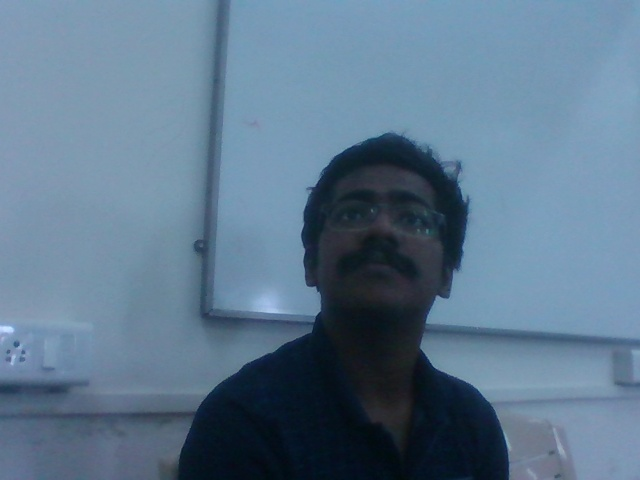

In [24]:
c, g, i = caption_image(
    finetuned_model,
    getImage()
)

In [25]:
c

['A man in a white shirt holding a cell phone.',
 'A man is holding a cell phone in his hand.',
 'A man sitting at a table with a laptop.',
 'A man sitting on a bench with a laptop.',
 'A man and a woman sitting at a table.']

In [12]:
generated_captions = []
for index in image_df.index:
    c, g, i = caption_image(
        finetuned_model,
        image_df['path'][index]
    )
    temp = []
    temp.append(image_df['caption'][index])
    temp.append(c)
    generated_captions.append(temp)

In [13]:
from nltk.translate.bleu_score import sentence_bleu
org_captions = []
pred_captions = []
for i in generated_captions:
    org_captions.append(i[0])
    pred_captions.append(i[1][0])

In [16]:
import json
jsonString = json.dumps(pred_captions)
jsonFile = open("pred_cap.json", "w")
jsonFile.write(jsonString)
jsonFile.close()

In [15]:
import nltk
nltk.download('punkt')

[nltk_data] Error loading punkt: <urlopen error [Errno 110] Connection
[nltk_data]     timed out>


False